# Replicating `hapi` behavior with `jax` and GPUs.

Here we replicate the behavior of `hapi` with GPU- and autodiff- aware `jax` framework.

In [1]:
%%capture
import astropy.units as u
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import hapi
hapi.db_begin('../../hapi/data/')

In [2]:
! du -hs ../../hapi/data/

272M	../../hapi/data/


### Convert from $\text{cm}^{-1}$ to Angstroms.

In [3]:
wls = (np.arange(15000, 25000, 1.0) * u.Angstrom)[::-1]
nus = wls.to(1/u.cm, equivalencies=u.spectral()).value
wls = wls.value
nu_lo, nu_hi = nus.min().astype(np.int), nus.max().astype(np.int)

You can calculate the partition function with HAPI.

In [4]:
hapi.partitionSum(1,1, [296])

[174.58122640000002]

Let's assign wet and dry atmospheric conditions.

In [5]:
h2o_vol_mix_ratio_wet = 1.0e-3
h2o_vol_mix_ratio_dry = 1.0e-6

In [6]:
nu, coeff = hapi.absorptionCoefficient_Lorentz(SourceTables='CO2', Diluent={'air':1.0, 'CO2':365.0e-6, 'H2O':h2o_vol_mix_ratio_wet}, WavenumberGrid=nus.tolist(),HITRAN_units=True)
nu, coeffw = hapi.absorptionCoefficient_Lorentz(SourceTables='H2O', Diluent={'air':1.0-h2o_vol_mix_ratio_wet, 'H2O':h2o_vol_mix_ratio_wet, 'CO2':365.0e-6}, WavenumberGrid=nus.tolist(), HITRAN_units=True)
nu, coeffd = hapi.absorptionCoefficient_Lorentz(SourceTables='H2O', Diluent={'air':1.0-h2o_vol_mix_ratio_dry, 'H2O':h2o_vol_mix_ratio_dry, 'CO2':365.0e-6}, WavenumberGrid=nus.tolist(), HITRAN_units=True)#range(4000,10000,1))

{'air': 1.0, 'CO2': 0.000365, 'H2O': 0.001}
{'air': 0.999, 'H2O': 0.001, 'CO2': 0.000365}
{'air': 0.999999, 'H2O': 1e-06, 'CO2': 0.000365}


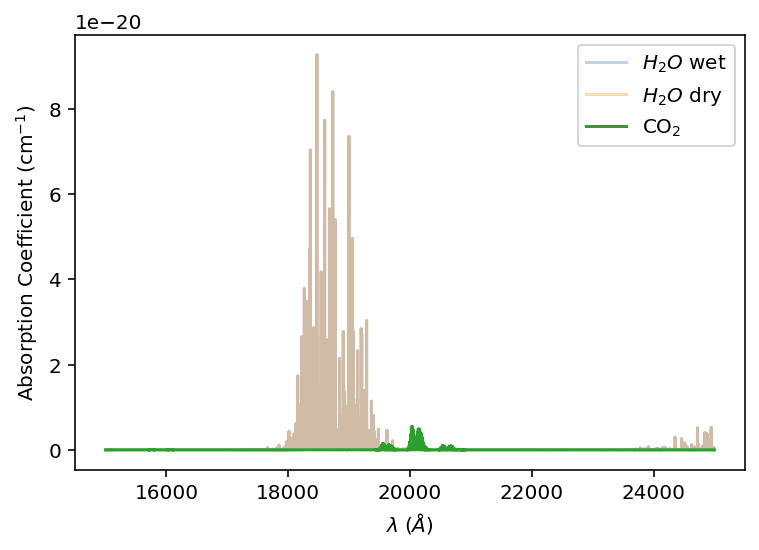

In [7]:
plt.plot(wls, coeffw, label='$H_2O$ wet', alpha=0.3)
plt.plot(wls, coeffd, label='$H_2O$ dry', alpha=0.3)
plt.plot(wls, coeff, label='CO$_2$')
plt.legend()
plt.ylabel('Absorption Coefficient (cm$^{-1}$)')
plt.xlabel('$\lambda \;(\AA)$');

That's the absorption cross section.  Later, we can get the absorption spectrum, which requires knowledge of the path length.

### Direct computation with GPUs

In [8]:
from jax.config import config
config.update("jax_enable_x64", True)

In [9]:
import jax.numpy as np
from jax import vmap, jit, grad, random

Compute Lorentz Profiles:  
$$ f_{L}(\nu; \nu_{ij}, T, p) = \frac{1}{\pi}\frac{\gamma(p, T)}{\gamma(p,T)^2, + [\nu-(\nu_{ij}+\delta(p_{ref})p)]^2}$$

We'll make an array that is $N_{lines} \times N_{wl}$ in size

In [10]:
@jit
def gamma_of_p_and_T(p, T, p_self, n_air, gamma_air_ref, gamma_self_ref):
    '''Compute the Lorentz HWHM with pressure and temp'''
    return (296.0/T)**n_air *(gamma_air_ref*(p-p_self) + gamma_self_ref*(p_self))

Let's try to map this function across all entries in the water line list.

In [11]:
n_air = hapi.getColumn('H2O', 'n_air')
gamma_air = hapi.getColumn('H2O', 'gamma_air')
gamma_self = hapi.getColumn('H2O', 'gamma_self')

In [12]:
%%time
gammas = vmap(gamma_of_p_and_T, in_axes=(None, None, None, 0, 0, 0)\
                                )(1.0, 296.0,0.1, n_air, gamma_air, gamma_self)

CPU times: user 88.9 ms, sys: 140 ms, total: 229 ms
Wall time: 309 ms


Yay!  We have our gammas to input into the Lorentz profile function

In [13]:
@jit
def lorentz_profile(nu, p, nu_ij, gamma, dp_ref, S_ij):
    '''Return the Lorentz line profile given vectors and parameters'''
    return S_ij/np.pi * gamma / ( gamma**2 + (nu - (nu_ij + dp_ref*p))**2)

In [14]:
nu_lines = hapi.getColumn('H2O', 'nu')
delta_air = hapi.getColumn('H2O', 'delta_air')
S_ij = hapi.getColumn('H2O', 'sw')

In [15]:
nus, wls = np.array(nus), np.array(wls)
nus.shape, gammas.shape

In [17]:
%%time
line_profile = vmap(lorentz_profile, in_axes=(None, None, 0, 0,0, 0))(nus, np.array(1.0),
                                                                      nu_lines, gammas, delta_air, S_ij)
line_profile.shape, S_ij.shape

CPU times: user 18.7 ms, sys: 7.98 ms, total: 26.7 ms
Wall time: 73.9 ms


Nice!  The *net* absorption coefficient is the sum on all lines:

In [19]:
%%time
net_abs_coeff = line_profile.sum(axis=0)

CPU times: user 15 ms, sys: 8.02 ms, total: 23 ms
Wall time: 73.3 ms


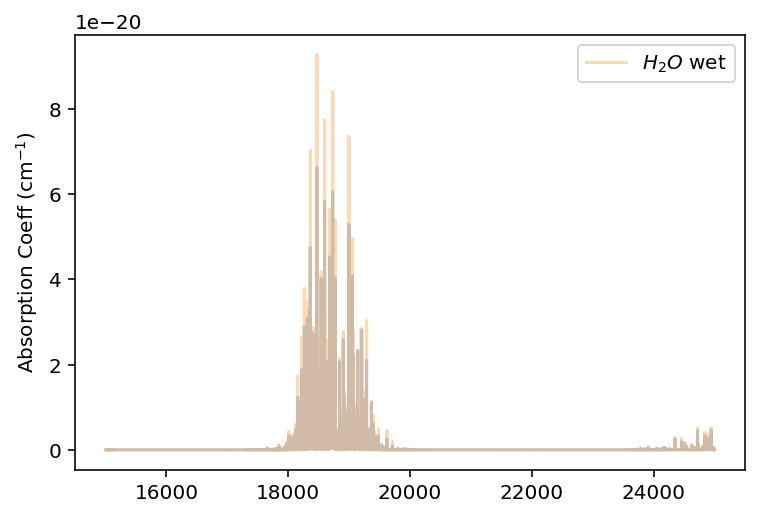

In [22]:
plt.plot(wls, net_abs_coeff, alpha=0.3, label='jax/GPU-based calculation')


plt.plot(wls, coeffw, label='$H_2O$ wet', alpha=0.3)
plt.yscale('linear')
plt.ylabel('Absorption Coeff (cm$^{-1}$)')
plt.legend();

Woohoo, pretty close!!  But not exact.  Let's investigate why.

In [21]:
hapi.describeTable('H2O')

-----------------------------------------
H2O summary:
-----------------------------------------
Number of rows: 44902
Table type: column-fixed
-----------------------------------------
            PAR_NAME           PAR_FORMAT

            molec_id                  %2d
        local_iso_id                  %1d
                  nu               %12.6f
                  sw               %10.3E
                   a               %10.3E
           gamma_air                %5.4f
          gamma_self                %5.3f
              elower               %10.4f
               n_air                %4.2f
           delta_air                %8.6f
 global_upper_quanta                 %15s
 global_lower_quanta                 %15s
  local_upper_quanta                 %15s
  local_lower_quanta                 %15s
                ierr                  %6s
                iref                 %12s
    line_mixing_flag                  %1s
                  gp                %7.1f
               